# Preprocessing Examples
This walkthrough covers selected functions from `functime.preprocessing`. We visualize common time-series preprocessing techniques before and after the time-series transformation. These transformations make the time-series look more "well-behaved", which generally makes the time-series easier to forecast. This chapter https://otexts.com/fpp3/stationarity.html from the Forecasting: Principles and Practice textbook provides an excellent primer on this topic.

In [1]:
import polars as pl

from functime.plotting import plot_forecasts, plot_panel
from functime.preprocessing import (
    boxcox,
    deseasonalize_fourier,
    detrend,
    diff,
    fractional_diff,
    scale,
    yeojohnson,
)

Let's first load the commodity prices dataset.

In [2]:
data = pl.read_parquet("../../data/commodities.parquet")
entity_col, time_col, target_col = data.columns
data.head(1)

commodity_type,time,price
str,datetime[ns],f64
"""Aluminum""",1960-01-01 00:00:00,511.47


There are 71 commodities in total.

In [3]:
data.get_column("commodity_type").n_unique()

71

Let's now visualize the top 4 most volatile time-series by coefficient of variation.

In [4]:
most_volatile_commodities = (
    data.group_by(entity_col)
    .agg((pl.col(target_col).std() / pl.col(target_col).mean()).alias("cv"))
    .top_k(k=4, by="cv")
)
most_volatile_commodities

commodity_type,cv
str,f64
"""Natural gas, E…",1.341444
"""Phosphate rock…",1.104353
"""Potassium chlo…",1.070662
"""Crude oil, Dub…",0.987116


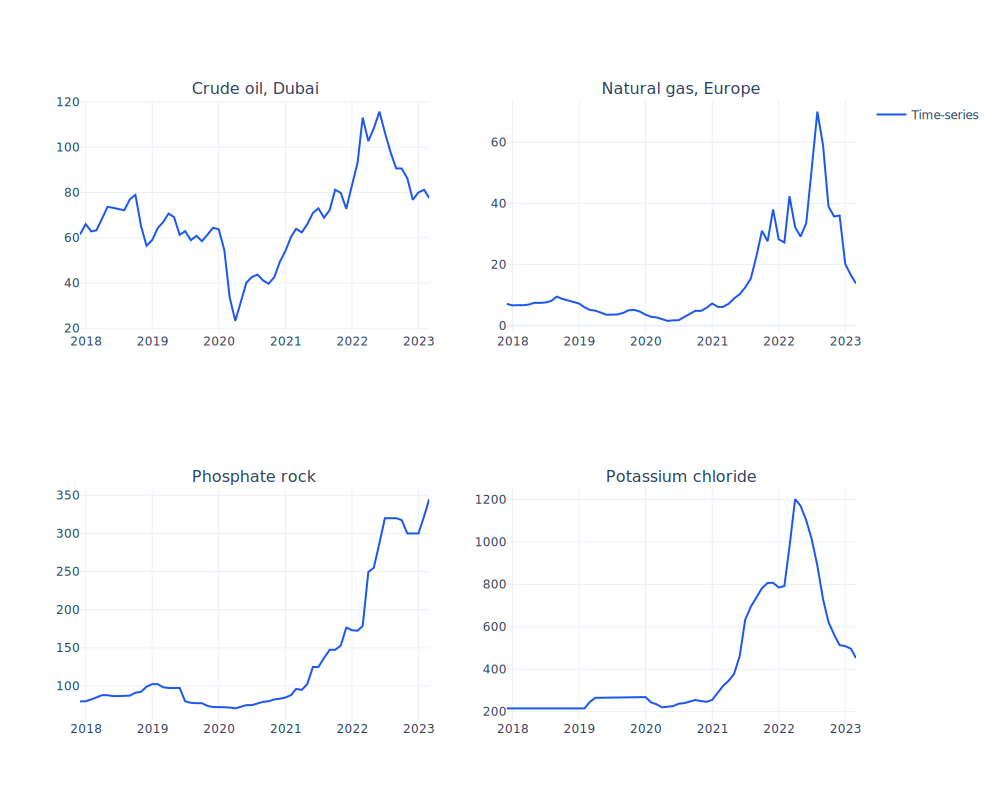

In [5]:
selected = most_volatile_commodities.get_column(entity_col)
y = data.filter(pl.col(entity_col).is_in(selected))
figure = plot_panel(y=y, height=800, width=1000)
figure.show(renderer="svg")

These time-series looks quite complex: trending behavior, seasonality effects, changing volatility over time, etc. Let's see if we can preprocess these time-series to make them easier to forecast!

## Detrending

We can use the `plot_forecasts` function to compare the time-series before and after the transformation.

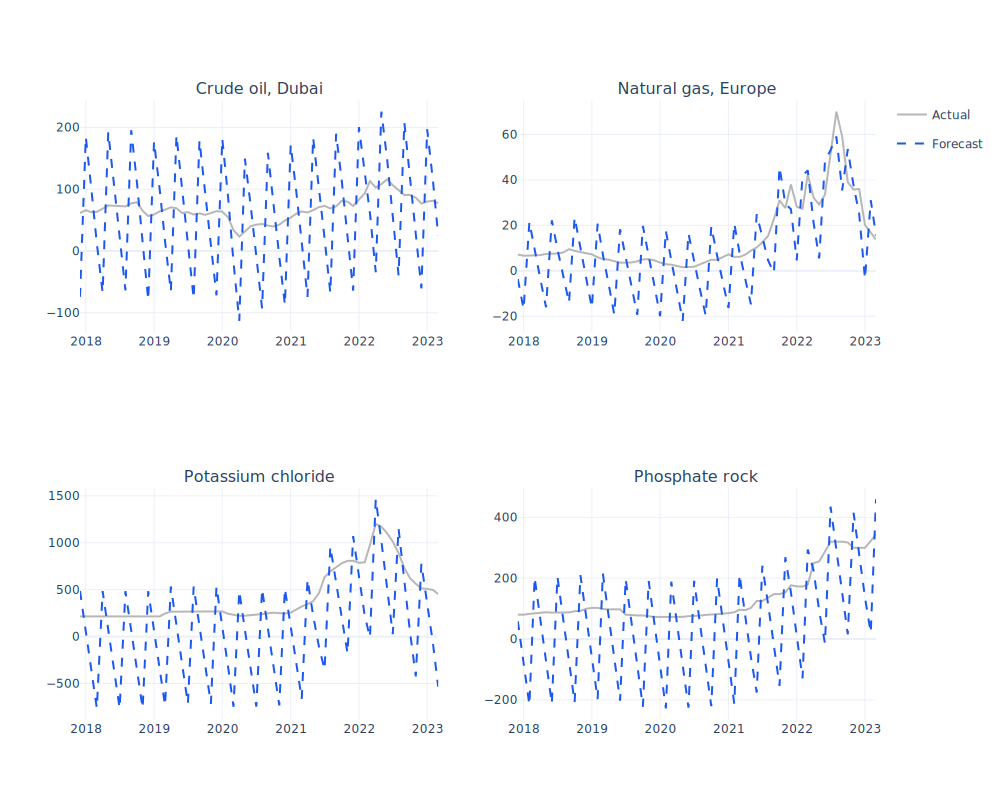

In [6]:
transformer = detrend(freq="1mo", method="linear")
y_detrended = y.pipe(transformer).collect()
figure = plot_forecasts(
    y_true=y, y_pred=y_detrended.group_by(entity_col).tail(64), height=800, width=1000
)
figure.show(renderer="svg")

It's super easy to invert the transformation!

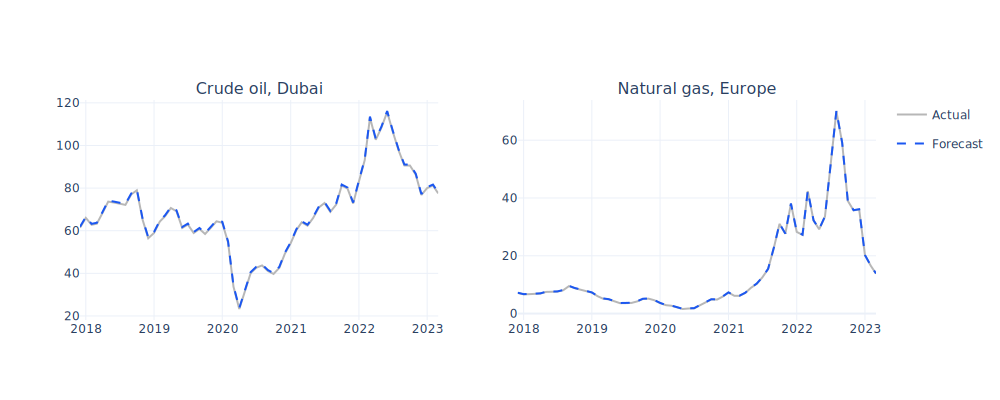

In [7]:
y_original = transformer.invert(y_detrended).group_by(entity_col).tail(64).collect()
subset = ["Natural gas, Europe", "Crude oil, Dubai"]
figure = plot_forecasts(
    y_true=y.filter(pl.col(entity_col).is_in(subset)),
    y_pred=y_original,
    height=400,
    width=1000,
)
figure.show(renderer="svg")

## Deseasonalize
We support deseasonalization via residualized regression on Fourier terms to model seasonality. For this example, let's use the M4 hourly dataset, which has clear seasonal patterns.

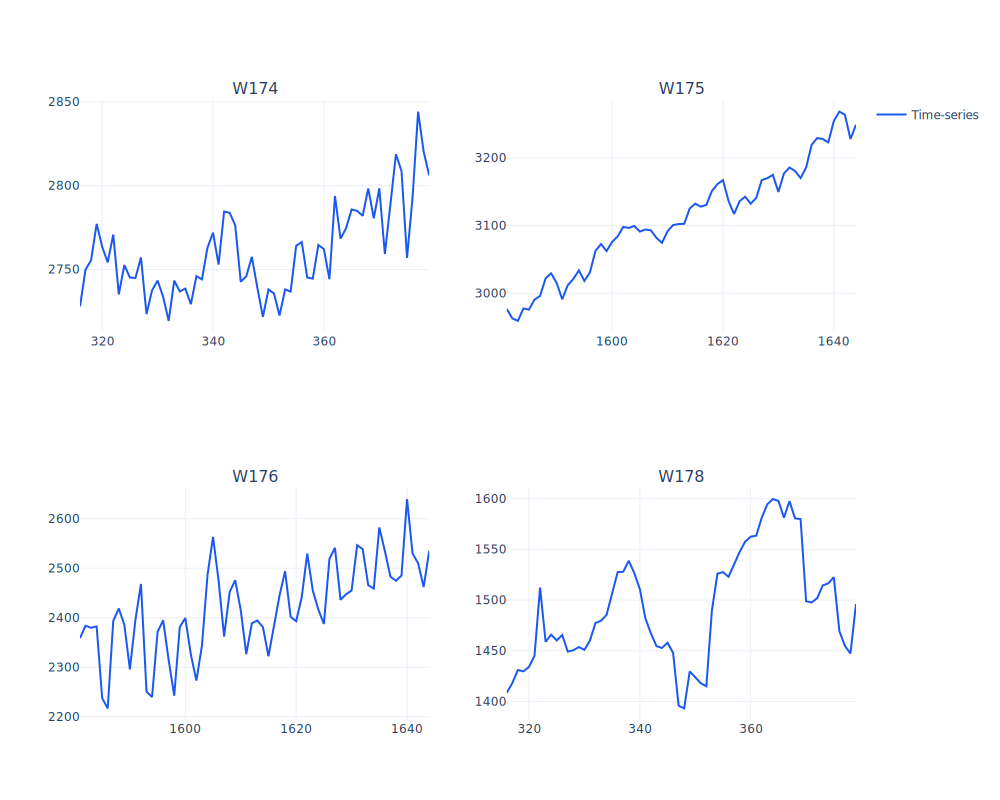

In [8]:
m4_data = pl.read_parquet("../../data/m4_1w_train.parquet")
m4_entity_col, m4_time_col, m4_target_col = m4_data.columns
y_m4 = m4_data.filter(pl.col(m4_entity_col).is_in(["W174", "W175", "W176", "W178"]))
figure = plot_panel(y=y_m4, height=800, width=1000)
figure.show(renderer="svg")

Let's plot the seasonal component of the series!

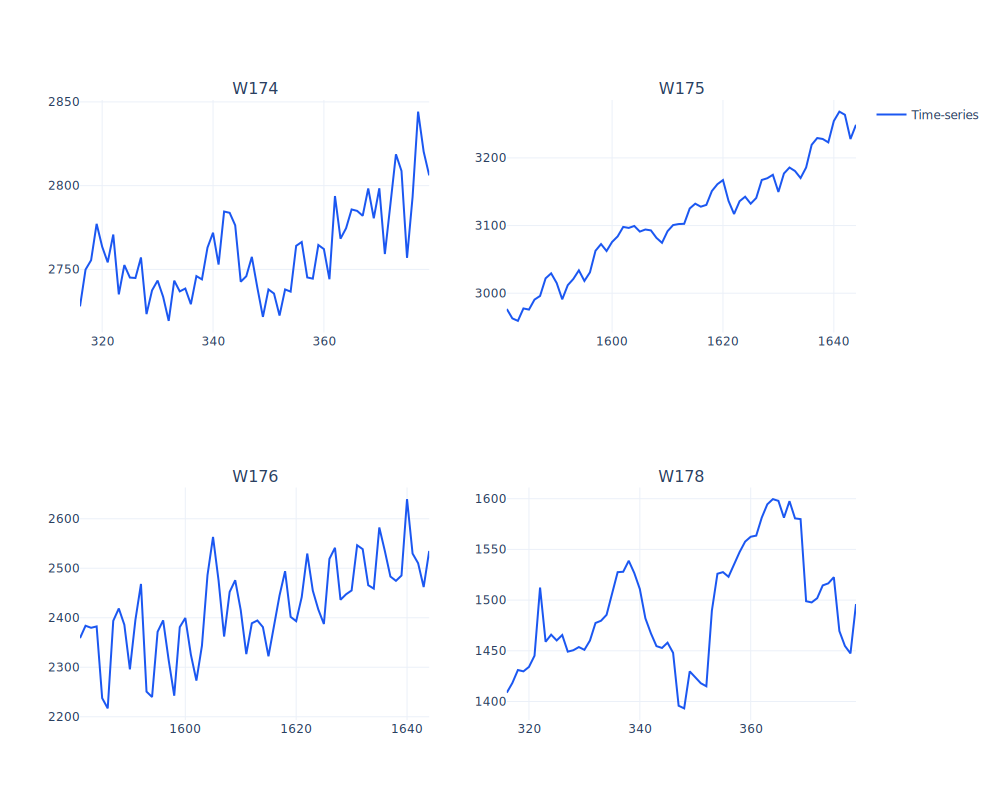

In [9]:
# Fourier Terms
transformer = deseasonalize_fourier(sp=12, K=3)
y_deseasonalized = y_m4.pipe(transformer).collect()
y_seasonal = transformer.state.artifacts["X_seasonal"].collect()
figure = plot_panel(
    y=y_seasonal.group_by(m4_entity_col).tail(64), height=800, width=1000
)
figure.show(renderer="svg")

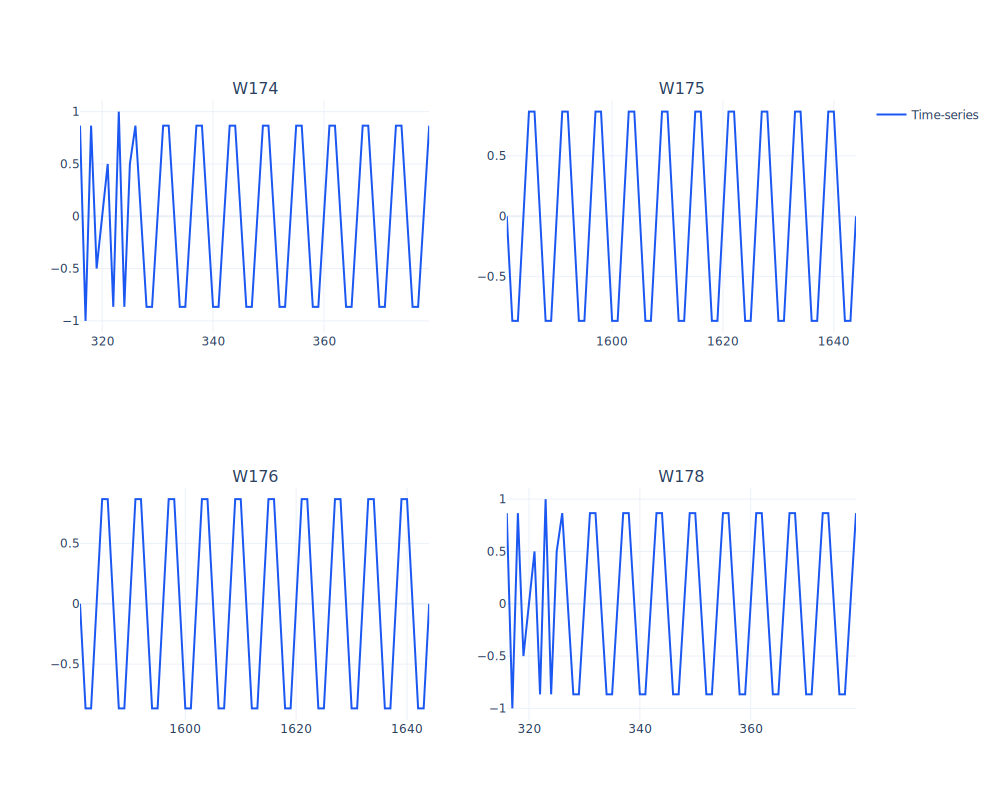

In [10]:
y_deseasonalized = y_m4.pipe(transformer).collect()
y_original = transformer.invert(y_deseasonalized).collect()
figure = plot_panel(
    y=y_original.group_by(m4_entity_col).tail(64), height=800, width=1000
)
figure.show(renderer="svg")

## Differencing
First differences is a technique used in time-series analysis to transform a non-stationary time-series into a stationary one by taking the difference between consecutive observations. Assumes the time-series is integrated with unit root 1.


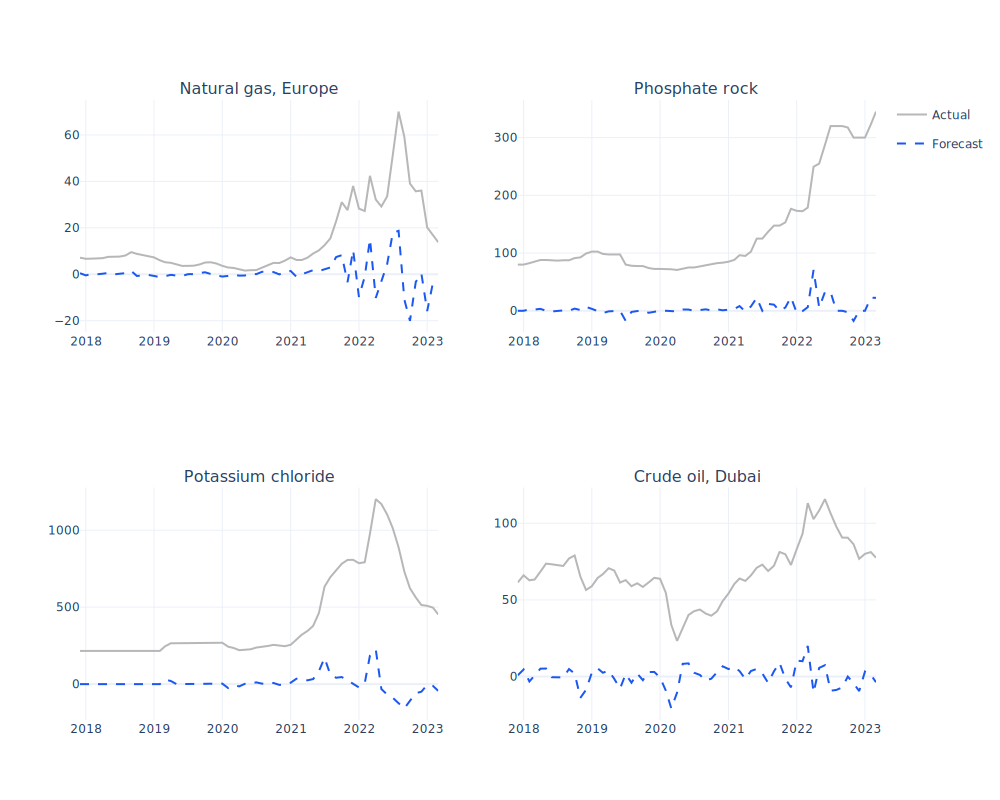

In [11]:
transformer = diff(order=1)
y_diff = y.pipe(transformer).collect()
figure = plot_forecasts(
    y_true=y, y_pred=y_diff.group_by(entity_col).tail(64), height=800, width=1000
)
figure.show(renderer="svg")

## Fractional Differencing

Sometimes you may want to make a time series stationary without removing all of the memory from a time series. This can especially be useful in specific forecasting tasks where the next value is dependent on a long history of past values (think forecasting the price of a stock). In this case, we can use fractional differencing. Notice the difference between these plots and the previous plots. It is worthwhile to run multiple tests using a scoring function such as the augmented dickey-fuller test to determine the minimum value of d that makes a time series stationary.

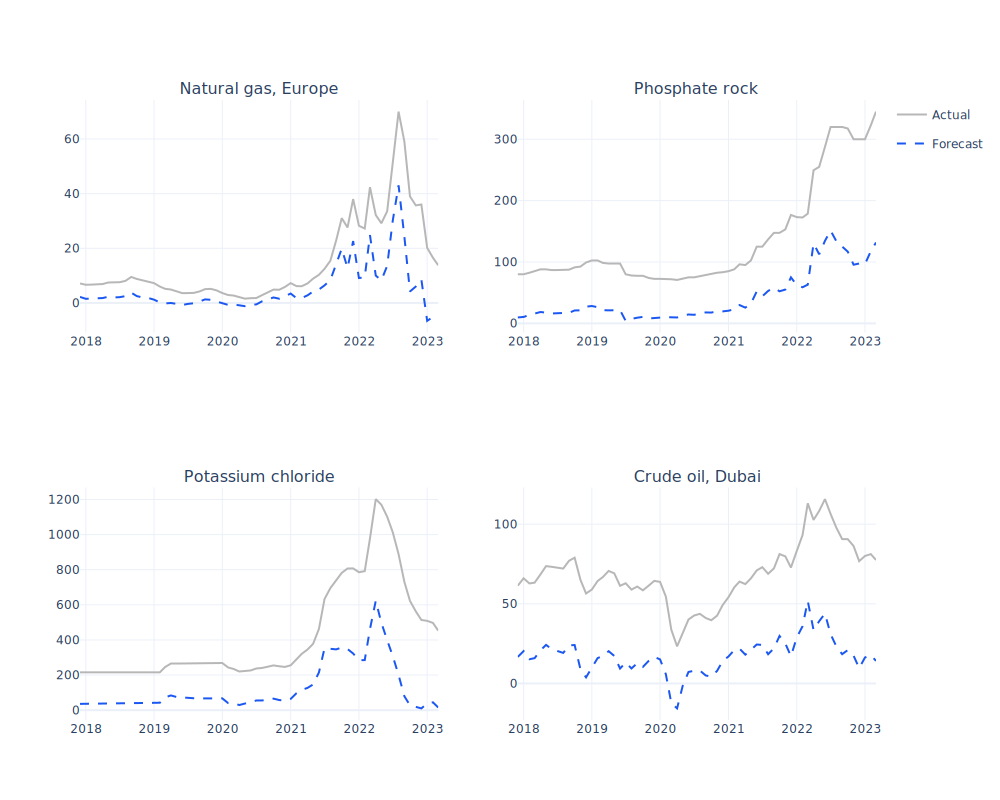

In [29]:
transformer = fractional_diff(d=0.3, min_weight=1e-3)
y_diff = y.pipe(transformer).collect()
figure = plot_forecasts(
    y_true=y, y_pred=y_diff.group_by(entity_col).tail(64), height=800, width=1000
)
figure.show(renderer="svg")

## Seasonal Differencing

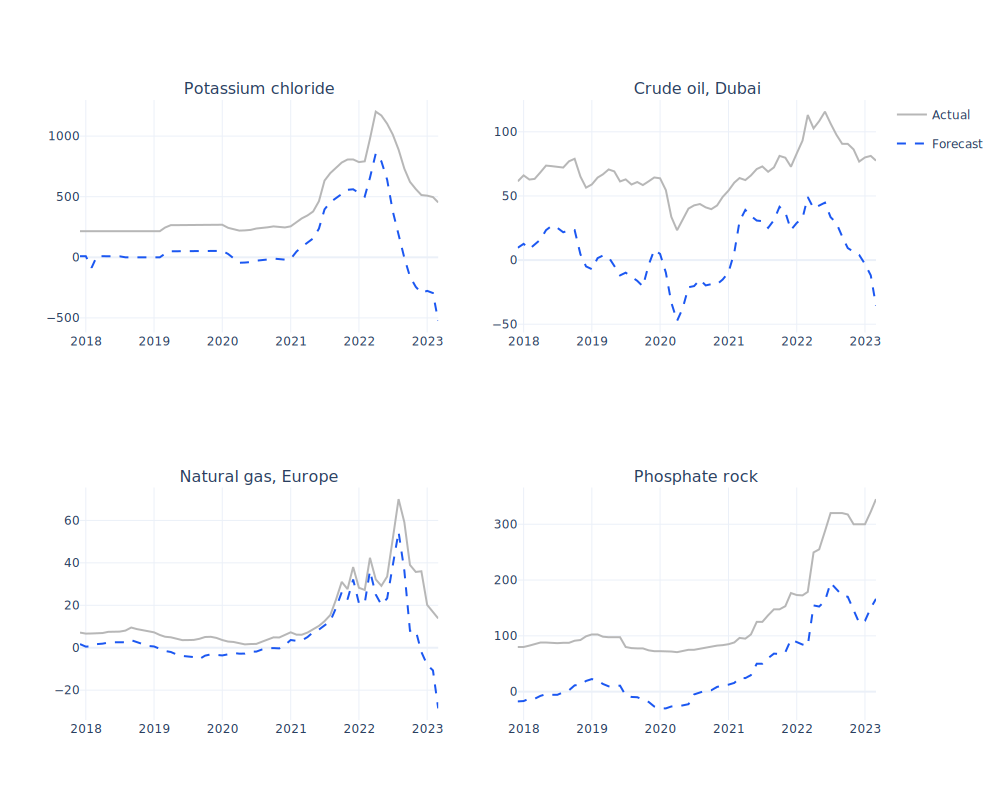

In [18]:
transformer = diff(order=1, sp=12)
y_seas_diff = y.pipe(transformer).collect()
figure = plot_forecasts(
    y_true=y, y_pred=y_seas_diff.group_by(entity_col).tail(64), height=800, width=1000
)
figure.show(renderer="svg")

## Local Scaling
Parallelized version of the scaling transformation (less mean, divide standard deviation) across many time-series.

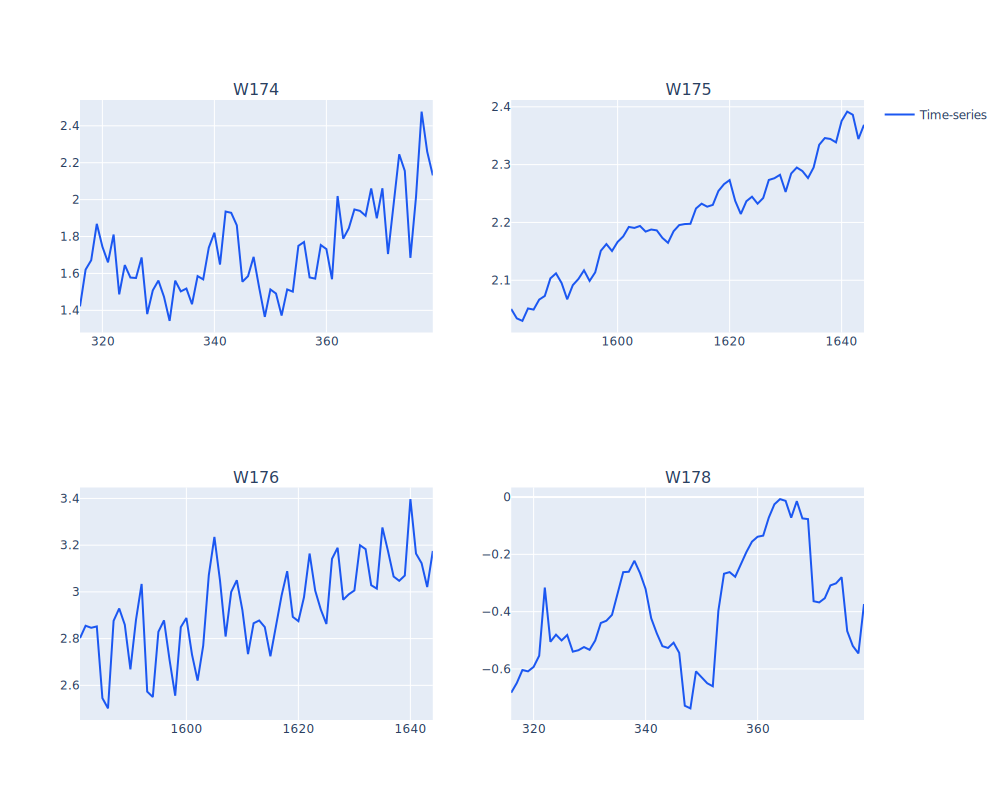

In [13]:
transformer = scale(use_mean=True, use_std=True)
y_scaled = y_m4.pipe(transformer).collect()
figure = plot_panel(y=y_scaled.group_by(m4_entity_col).tail(64), height=800, width=1000)
figure.show(renderer="svg")

## Box-Cox
This transformation is used to stabilize the variance of the time-series. Requires all values to be positive.

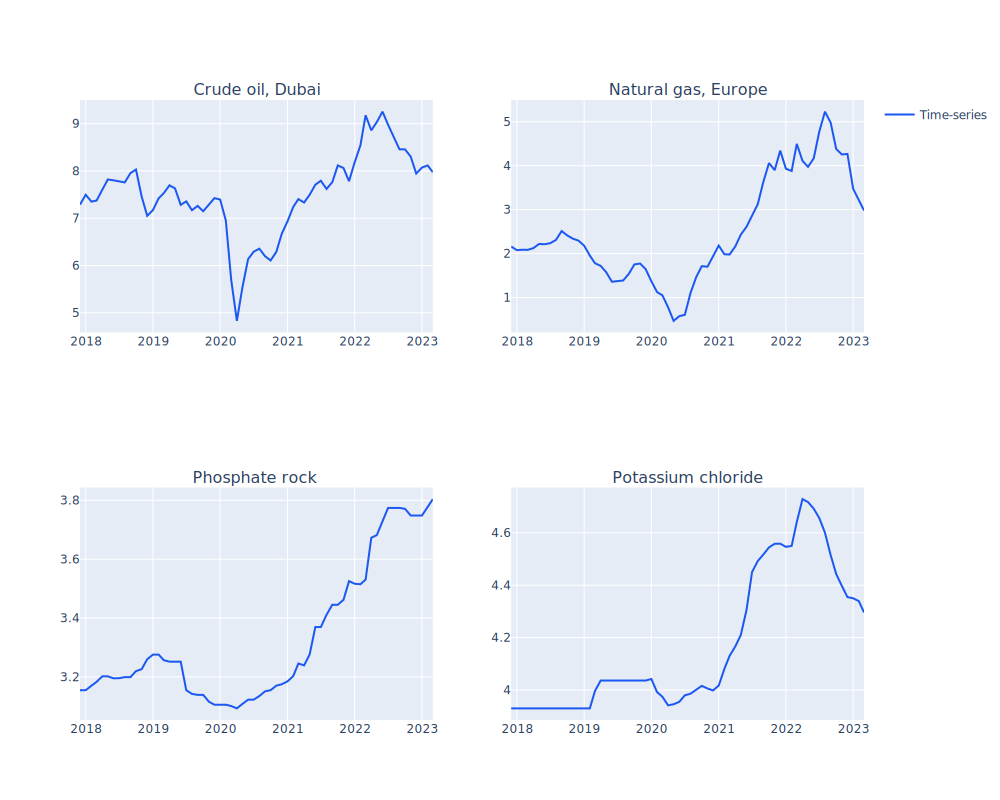

In [14]:
transformer = boxcox(method="mle")
y_boxcox = y.pipe(transformer).collect()
figure = plot_panel(y=y_boxcox.group_by(entity_col).tail(64), height=800, width=1000)
figure.show(renderer="svg")

## Yeo-Johnson
This transformation is similar to Box-Cox, but without the strictly positive requirement.

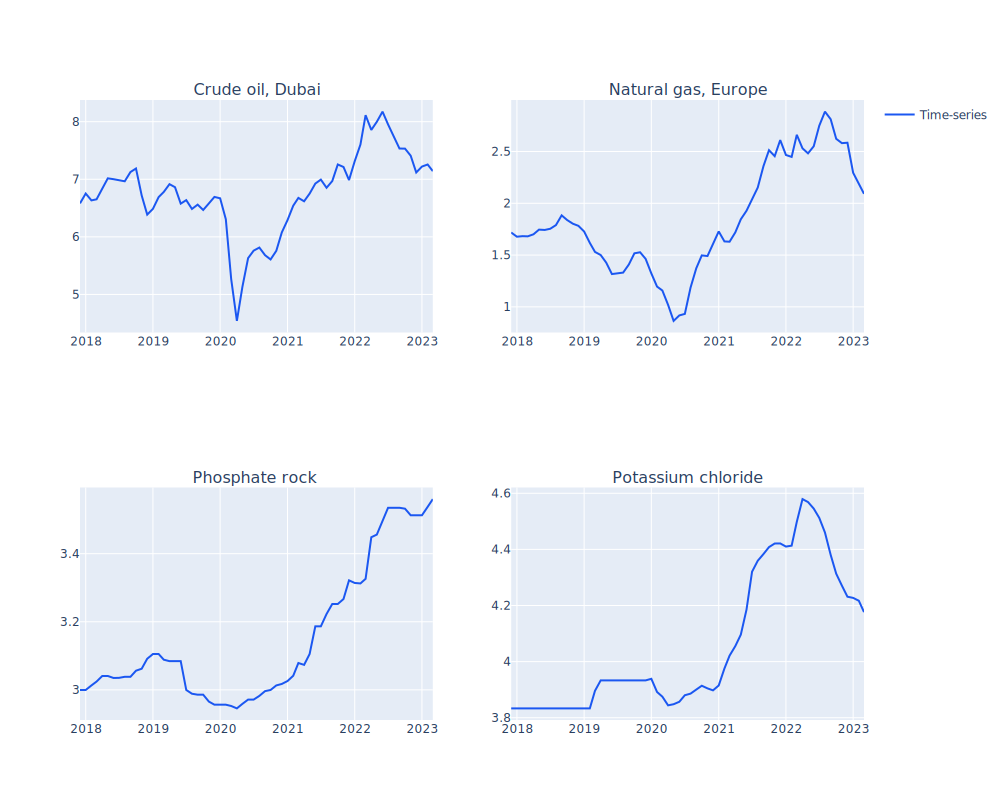

In [15]:
transformer = yeojohnson()
y_yeojohnson = y.pipe(transformer).collect()
figure = plot_panel(
    y=y_yeojohnson.group_by(entity_col).tail(64), height=800, width=1000
)
figure.show(renderer="svg")

## Let's put it all together!
- Box-Cox to stabilize the variance
- Deseasonalize to remove seasonality
- First differences to stabilize the mean

The goal is to make the time-series "look" more stationary, which is an important assumption for many time-series forecasting models. Here's an excellent primer on the topic: https://otexts.com/fpp3/stationarity.html

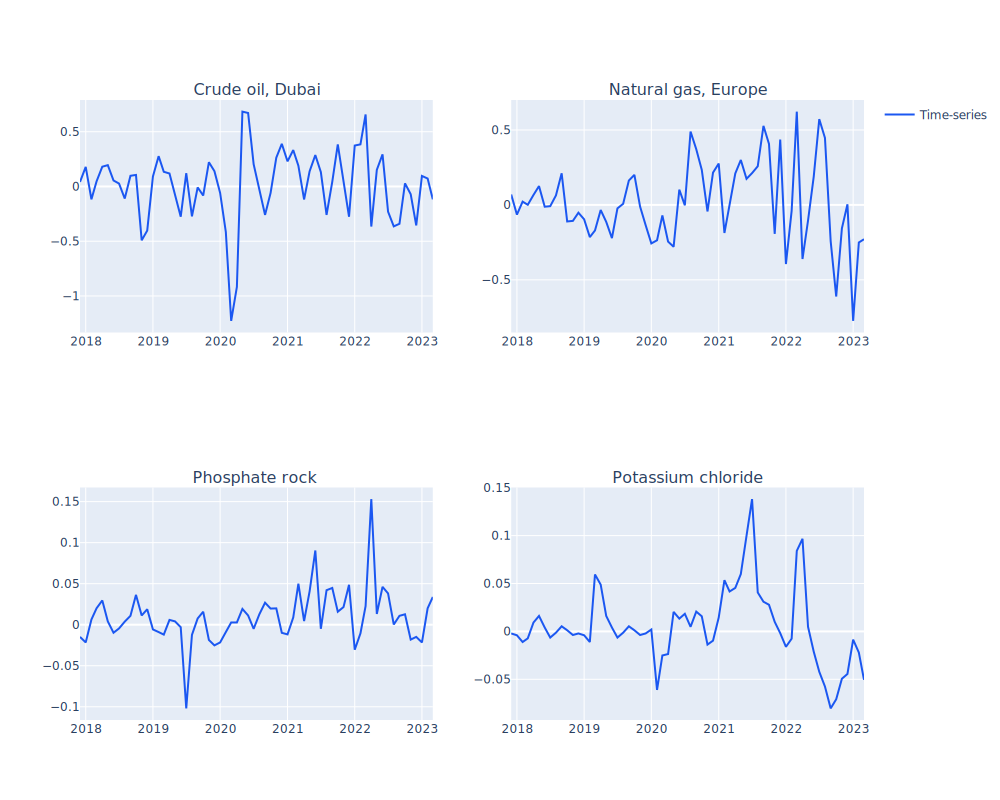

In [16]:
y_new = (
    y.pipe(boxcox())
    .pipe(deseasonalize_fourier(sp=12, K=3))
    .pipe(diff(order=1))
    .collect()
)
figure = plot_panel(y=y_new.group_by(entity_col).tail(64), height=800, width=1000)
figure.show(renderer="svg")